In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import seaborn as sns
import pandas as pd
import cv2 as cv
import lpips
import torch

from config import DATA_PATH, VIDEOS_PATH

In [4]:
file_path = f"{DATA_PATH}IRCCyN_IVC_DIBR_Videos_Scores.xls"

df_base= pd.read_excel(file_path, skiprows=[0])
nb = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
df_cleaned = df_base.drop(columns=nb)
df_videos = df_cleaned.drop(columns=['Unnamed: 33', 'std'])
df_videos = df_videos.rename(columns={'Unnamed: 0': 'Video'})
df_videos.head()

,Video,MOS,CI
0,Fehn_c_Book_arrival_bh_8_to_10,2.21875,0.270256
1,Fehn_c_Book_arrival_bh_10_to_8,2.15625,0.301427
2,Fehn_c_Book_arrival_sh_8_to_9,3.40625,0.298299
3,Fehn_c_Book_arrival_sh_10_to_9,3.56250,0.258958
4,Fehn_i_Book_arrival_bh_8_to_10,2.03125,0.280474


In [ ]:
# Adding video path by matching the MOS columns
df_base_DMOS = pd.read_excel(file_path, sheet_name='DMOS', skiprows=[0])
df_cleaned_DMOS = df_base_DMOS[['Unnamed: 0', 'MOS']]
df_cleaned_DMOS = df_cleaned_DMOS.rename(columns={'Unnamed: 0': 'Video_path'})

if (df_cleaned_DMOS['MOS'].values == df_videos['MOS'].values).all():
    df_videos['Video_path'] = df_cleaned_DMOS['Video_path'].values
    df_videos[['Video', 'Video_path', 'MOS']].head()
else:
    print("Les colonnes MOS ne correspondent pas!")


In [5]:
df_videos["Algo"] = pd.Series(dtype='object')
df_videos["Video_ID"] = pd.Series(dtype='object')
for index, row in df_videos.iterrows():
    video_name = row["Video"]

    if "Book_arrival" in video_name or "book_arrival" in video_name:
        df_videos.at[index, "Video_ID"] = "Book_arrival"
    elif "Lovebird1" in video_name or "lovebird1" in video_name or 'lovebird' in video_name:
        df_videos.at[index, "Video_ID"] = "Lovebird1"
    elif "Newspaper" in video_name or "newspaper" in video_name:
        df_videos.at[index, "Video_ID"] = "Newspaper"

    if "Fehn_c" in video_name:
        df_videos.at[index, "Algo"] = "Fehn_c"
    elif "Fehn_i" in video_name:
        df_videos.at[index, "Algo"] = "Fehn_i"
    elif "Holes" in video_name:
        df_videos.at[index, "Algo"] = "Holes"
    elif "ICIP_TMM" in video_name:
        df_videos.at[index, "Algo"] = "ICIP_TMM"
    elif "ICME" in video_name:
        df_videos.at[index, "Algo"] = "ICME"
    elif "MPEG" in video_name:
        df_videos.at[index, "Algo"] = "MPEG"
    elif "Muller" in video_name:
        df_videos.at[index, "Algo"] = "Muller"
    else : 
        df_videos.at[index, "Algo"] = "Original"
    

In [ ]:
df_videos.head()

,Video,MOS,CI,Video_path,Algo,Video_ID
0,Fehn_c_Book_arrival_bh_8_to_10,2.21875,0.270256,Book_arrival_A1_8_to_10.avi,Fehn_c,Book_arrival
1,Fehn_c_Book_arrival_bh_10_to_8,2.15625,0.301427,Book_arrival_A1_10_to_8.avi,Fehn_c,Book_arrival
2,Fehn_c_Book_arrival_sh_8_to_9,3.40625,0.298299,Book_arrival_A1_8_to_9.avi,Fehn_c,Book_arrival
3,Fehn_c_Book_arrival_sh_10_to_9,3.56250,0.258958,Book_arrival_A1_10_to_9.avi,Fehn_c,Book_arrival
4,Fehn_i_Book_arrival_bh_8_to_10,2.03125,0.280474,Book_arrival_A2_8_to_10.avi,Fehn_i,Book_arrival


### Staistical analysis of MOS and CI

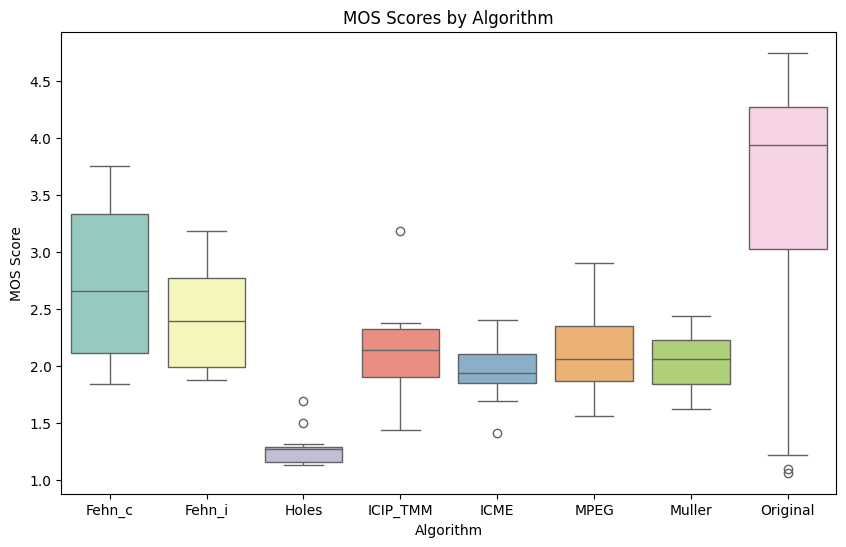

In [6]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Algo", y="MOS", data=df_videos, hue="Algo", palette="Set3", legend=False)
plt.title("MOS Scores by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("MOS Score")
plt.show()

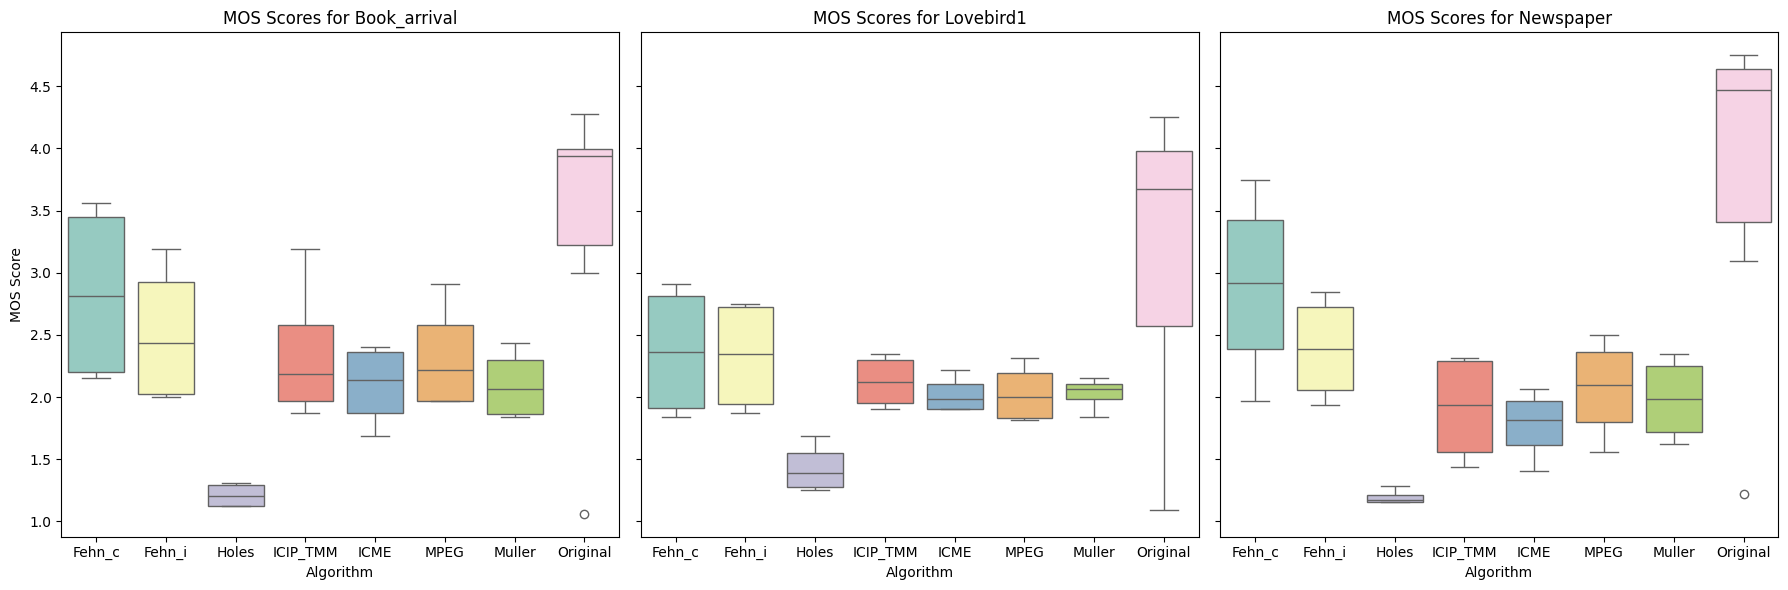

In [ ]:
video_ids = df_videos["Video_ID"].unique()
fig, axes = plt.subplots(1, len(video_ids), figsize=(18,6), sharey=True)
for i, video_id in enumerate(video_ids):
    ax = axes[i]
    subset = df_videos[df_videos["Video_ID"] == video_id]
    sns.boxplot(x="Algo", y="MOS", data=subset, hue="Algo", palette="Set3", ax=ax, legend=False)
    ax.set_title(f"MOS Scores for {video_id}")
    ax.set_xlabel("Algorithm")
    if i == 0:
        ax.set_ylabel("MOS Score")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
print("Algorithm\t\tMean MOS ± CI")
print("-" * 50)
for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    mean_mos = subset['MOS'].mean()
    mean_ci = subset['CI'].mean()
    print(f"{algo:15s}\t{mean_mos:.3f} ± {mean_ci:.3f}  [{mean_mos-mean_ci:.3f}, {mean_mos+mean_ci:.3f}]")

Algorithm		Mean MOS ± CI
--------------------------------------------------
Fehn_c         	2.698 ± 0.282  [2.415, 2.980]
Fehn_i         	2.411 ± 0.263  [2.149, 2.674]
Holes          	1.279 ± 0.159  [1.120, 1.438]
ICIP_TMM       	2.130 ± 0.215  [1.915, 2.346]
ICME           	1.964 ± 0.223  [1.741, 2.186]
MPEG           	2.141 ± 0.225  [1.916, 2.366]
Muller         	2.039 ± 0.222  [1.817, 2.261]
Original       	3.436 ± 0.246  [3.190, 3.681]


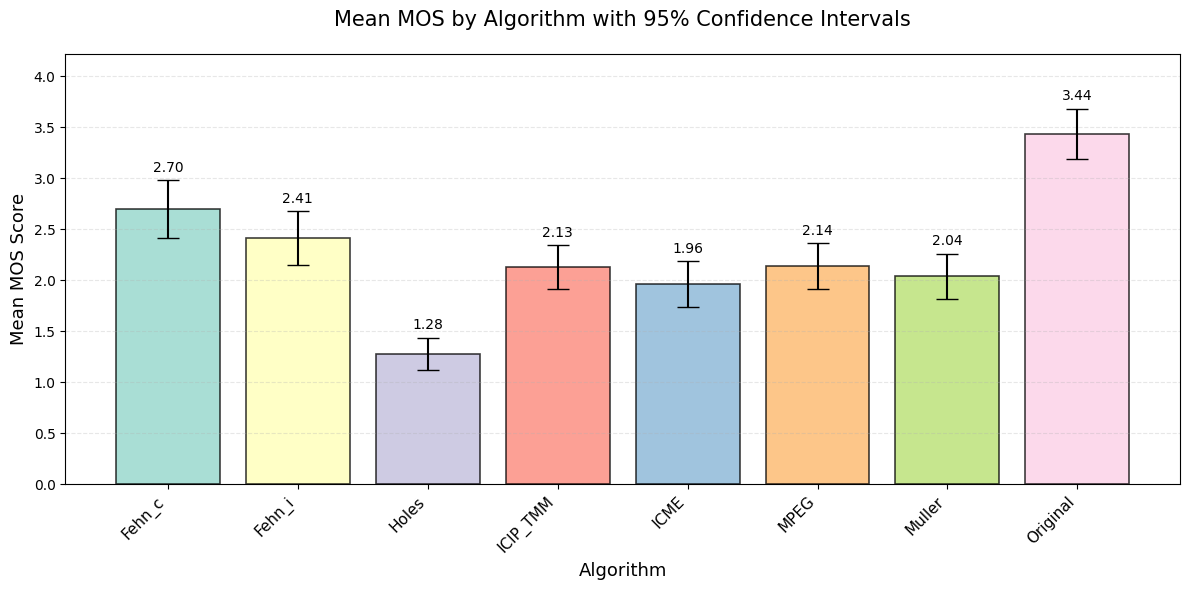

Non-overlapping CIs suggest statistically significant differences


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

algos = sorted(df_videos['Algo'].unique())
means = []
cis = []

for algo in algos:
    subset = df_videos[df_videos['Algo'] == algo]
    means.append(subset['MOS'].mean())
    cis.append(subset['CI'].mean())

x_pos = np.arange(len(algos))
bars = ax.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.75, 
               color=sns.color_palette("Set3", len(algos)), 
               edgecolor='black', linewidth=1.2)

for i, (m, c) in enumerate(zip(means, cis)):
    ax.text(i, m + c + 0.05, f'{m:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Algorithm', fontsize=13)
ax.set_ylabel('Mean MOS Score', fontsize=13)
ax.set_title('Mean MOS by Algorithm with 95% Confidence Intervals', fontsize=15, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(algos, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(means) + max(cis) + 0.5)

plt.tight_layout()
plt.show()


print("Non-overlapping CIs suggest statistically significant differences")

In [83]:
# Statistical comparison: ANOVA test to check if there are significant differences between algorithms
from scipy.stats import f_oneway

# Prepare data for ANOVA
algo_groups = [group['MOS'].values for name, group in df_videos.groupby('Algo')]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*algo_groups)

print(f"One-Way ANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: There are statistically significant differences between algorithms (p < 0.05)")
else:
    print("\nConclusion: No statistically significant differences between algorithms (p >= 0.05)")

One-Way ANOVA Results:
F-statistic: 13.9396
P-value: 2.8475929891220266e-12

Conclusion: There are statistically significant differences between algorithms (p < 0.05)


In [8]:
#test de Dunnett
from statsmodels.stats.multicomp import pairwise_tukeyhsd
dunnett = pairwise_tukeyhsd(endog=df_videos['MOS'], groups=df_videos['Algo'], alpha=0.05)
print(dunnett)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  Fehn_c   Fehn_i  -0.2865 0.9576  -1.102  0.5291  False
  Fehn_c    Holes  -1.4193    0.0 -2.2348 -0.6037   True
  Fehn_c ICIP_TMM  -0.5677 0.3864 -1.3833  0.2478  False
  Fehn_c     ICME  -0.7344 0.1095 -1.5499  0.0812  False
  Fehn_c     MPEG  -0.5573 0.4109 -1.3728  0.2583  False
  Fehn_c   Muller  -0.6589 0.2064 -1.4744  0.1567  False
  Fehn_c Original   0.7378 0.0539 -0.0066  1.4823  False
  Fehn_i    Holes  -1.1328  0.001 -1.9484 -0.3173   True
  Fehn_i ICIP_TMM  -0.2812 0.9616 -1.0968  0.5343  False
  Fehn_i     ICME  -0.4479 0.6855 -1.2635  0.3676  False
  Fehn_i     MPEG  -0.2708 0.9687 -1.0864  0.5447  False
  Fehn_i   Muller  -0.3724 0.8478 -1.1879  0.4432  False
  Fehn_i Original   1.0243 0.0012  0.2798  1.7688   True
   Holes ICIP_TMM   0.8516 0.0342   0.036  1.6671   True
   Holes     ICME   0.6849 0.16

In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(df_videos['MOS'], df_videos['Algo'])

result = mc.tukeyhsd()

filtered_results = result.summary().data[1:] 
filtered_results = [row for row in filtered_results if 'Original' in row[0] or 'Original' in row[1]]
for rows in filtered_results:
    print(rows)

['Fehn_c', 'Original', np.float64(0.7378), np.float64(0.0539), np.float64(-0.0066), np.float64(1.4823), np.False_]
['Fehn_i', 'Original', np.float64(1.0243), np.float64(0.0012), np.float64(0.2798), np.float64(1.7688), np.True_]
['Holes', 'Original', np.float64(2.1571), np.float64(0.0), np.float64(1.4126), np.float64(2.9016), np.True_]
['ICIP_TMM', 'Original', np.float64(1.3056), np.float64(0.0), np.float64(0.5611), np.float64(2.05), np.True_]
['ICME', 'Original', np.float64(1.4722), np.float64(0.0), np.float64(0.7277), np.float64(2.2167), np.True_]
['MPEG', 'Original', np.float64(1.2951), np.float64(0.0), np.float64(0.5506), np.float64(2.0396), np.True_]
['Muller', 'Original', np.float64(1.3967), np.float64(0.0), np.float64(0.6522), np.float64(2.1412), np.True_]


In [42]:
print("=" * 70)
print("SUMMARY: Comparison of Each Algorithm vs. Original (Control)")
print("=" * 70)
print(f"{'Algorithm':<15} {'Mean Diff':<17} {'95% CI':<12} {'p-value':<6} {'Significant?'}")
print("-" * 70)

for row in filtered_results:
    group1, group2, meandiff, pval, lower, upper, reject = row
    if 'Original' in [group1, group2]:
        other_group = group1 if group2 == 'Original' else group2
        meandiff_adj = meandiff if group1 == 'Original' else -meandiff
        lower_adj = lower if group1 == 'Original' else -lower
        upper_adj = upper if group1 == 'Original' else -upper
        
        ci_str = f"[{lower_adj:6.3f}, {upper_adj:6.3f}]"
        sig_str = "YES" if reject else "NO"
        
        print(f"{other_group:<15} {meandiff_adj:>10.4f}  {ci_str:<20} {pval:>6}  {sig_str}")

print("=" * 70)
print("\nInterpretation:")
print("- Positive Mean Diff: Algorithm performs BETTER than Original")
print("- Negative Mean Diff: Algorithm performs WORSE than Original")
print("- Significant (p < 0.05): The difference is statistically meaningful")

SUMMARY: Comparison of Each Algorithm vs. Original (Control)
Algorithm       Mean Diff         95% CI       p-value Significant?
----------------------------------------------------------------------
Fehn_c             -0.7378  [ 0.007, -1.482]     0.0539  NO
Fehn_i             -1.0243  [-0.280, -1.769]     0.0012  YES
Holes              -2.1571  [-1.413, -2.902]        0.0  YES
ICIP_TMM           -1.3056  [-0.561, -2.050]        0.0  YES
ICME               -1.4722  [-0.728, -2.217]        0.0  YES
MPEG               -1.2951  [-0.551, -2.040]        0.0  YES
Muller             -1.3967  [-0.652, -2.141]        0.0  YES

Interpretation:
- Positive Mean Diff: Algorithm performs BETTER than Original
- Negative Mean Diff: Algorithm performs WORSE than Original
- Significant (p < 0.05): The difference is statistically meaningful


In [ ]:
def calculate_SI(frame):
    """
    Calculate Spatial Information (SI) for a frame.
    SI measures the spatial complexity/detail in the frame.
    
    SI = std(Sobel(frame))
    Higher SI = more spatial detail/edges
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply Sobel operator to detect edges
    sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # SI is the standard deviation of the Sobel filtered frame
    si = np.std(sobel)
    return si

def calculate_TI(frame1, frame2):
    """
    Calculate Temporal Information (TI) between two consecutive frames.
    TI measures the amount of motion/change between frames.
    
    TI = std(frame_diff)
    Higher TI = more motion/temporal change
    """
    # Convert to grayscale if needed
    if len(frame1.shape) == 3:
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    else:
        gray1 = frame1
        gray2 = frame2
    
    # Calculate frame difference
    diff = gray2.astype(np.float64) - gray1.astype(np.float64)
    
    # TI is the standard deviation of the frame difference
    ti = np.std(diff)
    return ti

def analyze_video_SI_TI(video_path, max_frames=300):
    """
    Analyze a video and return its SI and TI values.
    
    Parameters:
    - video_path: path to video file
    - max_frames: maximum number of frames to analyze (for efficiency)
    
    Returns:
    - mean_si: average SI across frames
    - max_si: maximum SI value
    - mean_ti: average TI across frame pairs
    - max_ti: maximum TI value
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None, None, None, None
    
    si_values = []
    ti_values = []
    prev_frame = None
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        
        si = calculate_SI(frame)
        si_values.append(si)
        
        if prev_frame is not None:
            ti = calculate_TI(prev_frame, frame)
            ti_values.append(ti)
        
        prev_frame = frame.copy()
        frame_count += 1
    
    cap.release()
    
    mean_si = np.mean(si_values) if si_values else 0
    max_si = np.max(si_values) if si_values else 0
    mean_ti = np.mean(ti_values) if ti_values else 0
    max_ti = np.max(ti_values) if ti_values else 0
    
    return mean_si, max_si, mean_ti, max_ti


In [45]:
# Calculate SI/TI for all videos in the dataset
df_videos['SI_mean'] = 0.0
df_videos['SI_max'] = 0.0
df_videos['TI_mean'] = 0.0
df_videos['TI_max'] = 0.0

print("Calculating SI/TI for all videos...")
print("This may take a few minutes...\n")

for index, row in df_videos.iterrows():
    video_name = row['Video']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    print(f"Video path: {video_path}")  
    
    if os.path.exists(video_path):
        print(f"Processing: {video_name[:50]}...")
        si_mean, si_max, ti_mean, ti_max = analyze_video_SI_TI(video_path)
        
        df_videos.at[index, 'SI_mean'] = si_mean
        df_videos.at[index, 'SI_max'] = si_max
        df_videos.at[index, 'TI_mean'] = ti_mean
        df_videos.at[index, 'TI_max'] = ti_max
    else:
        print(f"Video not found: {video_path}")

print("\n✓ SI/TI calculation complete!")
print("\nSample results:")
print(df_videos[['Video', 'Algo', 'MOS', 'SI_mean', 'TI_mean']].head(10))

Calculating SI/TI for all videos...
This may take a few minutes...

Video path: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_bh_8_to_10
Video not found: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_bh_8_to_10
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_bh_10_to_8
Video not found: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_bh_10_to_8
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_sh_8_to_9
Video not found: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_sh_8_to_9
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_sh_10_to_9
Video not found: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_c_Book_arrival_sh_10_to_9
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_i_Book_arrival_bh_8_to_10
Video not found: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_i_Book_arrival_bh_8_to_10
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_i_Book_arrival_bh_10_to_8
Video not found: IRCCyN_IVC_DIBR_Videos/Videos/Fehn_i_Book_arrival_bh_10_to_8
Video path: IRCCyN_IVC_DIBR_

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

scatter = axes[1].scatter(df_videos['SI_mean'], df_videos['TI_mean'], 
                         c=df_videos['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents one video")
print("- High SI = spatially complex content (detailed scenes)")
print("- High TI = high motion content")
print("- Colors in right plot show if high SI/TI correlates with lower/higher MOS")

#### Clustering 

### Objective QA : PSNR, VIF, LPIPS

In [6]:
def video_psnr(path_ref, path_dis, use_y_channel=True):
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break

        if use_y_channel:
            f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2YUV)[:,:,0]
            f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2YUV)[:,:,0]

        f_ref = f_ref.astype(np.float32)
        f_dis = f_dis.astype(np.float32)

        dr = f_dis.max() - f_dis.min() if use_y_channel else 255.0
        scores.append(psnr(f_ref, f_dis, data_range=dr))

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

In [10]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "sewar"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "sewar"])

Found existing installation: sewar 0.4.6
Uninstalling sewar-0.4.6:
  Successfully uninstalled sewar-0.4.6
  Using cached sewar-0.4.6-py3-none-any.whl


0

In [11]:
loss_fn_alex = lpips.LPIPS(net='alex') 

def video_lpips(path_ref, path_dis, device='cpu'):
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break

        f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2RGB)
        f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2RGB)

        f_ref = (f_ref / 127.5) - 1.0
        f_dis = (f_dis / 127.5) - 1.0

        tensor_ref = torch.from_numpy(f_ref).permute(2,0,1).unsqueeze(0).float().to(device)
        tensor_dis = torch.from_numpy(f_dis).permute(2,0,1).unsqueeze(0).float().to(device)

        with torch.no_grad():
            d = loss_fn_alex(tensor_ref, tensor_dis)
            scores.append(d.item())

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

def video_vif(path_ref, path_dis):
    """
    Calculate Visual Information Fidelity (VIF) for video frames using scikit-image SSIM.
    SSIM is a perceptual quality metric (range: -1 to 1, higher = better).
    Normalized to [0, 1] for consistency.
    """
    from skimage.metrics import structural_similarity as ssim
    
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break

        # Convert BGR to grayscale for SSIM (or use as RGB)
        f_ref_gray = cv.cvtColor(f_ref, cv.COLOR_BGR2GRAY).astype(np.float32)
        f_dis_gray = cv.cvtColor(f_dis, cv.COLOR_BGR2GRAY).astype(np.float32)

        # Compute SSIM (structural similarity, perceptual metric)
        # data_range should be the range of values (typically 255 for uint8)
        ssim_score = ssim(f_ref_gray, f_dis_gray, data_range=255)
        
        # Normalize SSIM from [-1, 1] to [0, 1]
        ssim_normalized = (ssim_score + 1) / 2
        scores.append(ssim_normalized)

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/raclax/miniconda3/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [ ]:
df_videos['PSNR'] = np.nan
df_videos['LPIPS_alex'] = np.nan
df_videos['VIF'] = np.nan

for index, row in df_videos.iterrows():
    video_name = row['Video']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    video_id = row['Video_ID']

    if row['Algo'] == 'Original':
        df_videos.at[index, 'PSNR'] = np.nan
        df_videos.at[index, 'LPIPS_alex'] = 0.0
        df_videos.at[index, 'VIF'] = 1.0  # Perfect information fidelity against itself
        continue

    video_ref = df_videos['Video'][(df_videos['Algo'] == 'Original') & (df_videos['Video_ID'] == video_id)].values[0]
    video_ref_path = os.path.join(VIDEOS_PATH, video_ref)

    print(f"Video path: {video_path}")  

    if os.path.exists(video_path) and os.path.exists(video_ref_path):
        print(f"Processing: {video_name[:50]}...")
        psnr_score = video_psnr(video_ref_path, video_path)
        lpips_score = video_lpips(video_ref_path, video_path)
        vif_score = video_vif(video_ref_path, video_path)

        df_videos.at[index, 'PSNR'] = psnr_score
        df_videos.at[index, 'LPIPS_alex'] = lpips_score
        df_videos.at[index, 'VIF'] = vif_score
    else:
        print(f"Video not found: {video_path}")

print("\n✓ Objective metrics computed (PSNR + LPIPS + VIF).")
df_videos[['Video', 'Algo', 'MOS', 'PSNR', 'LPIPS_alex', 'VIF']].head()